# Modelli

- PCA
- Locally Weighted Softmax
- FeedForward NN
- Convolutional NN

Provare anche a rimuovere le classi sotto-rappresentate o espandere il dataset

In [5]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
import torch
from torch import nn
import copy
import tqdm
from torch import optim



import utils

plt.rcParams['figure.figsize'] = (17, 5)

# valutazione
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y

def valuate(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title='Confusion matrix')

tracks = utils.load('./fma_metadata/tracks.csv')
features = utils.load('./fma_metadata/features.csv')

np.testing.assert_array_equal(features.index, tracks.index)
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium = tracks['set', 'subset'] <= 'medium'

X = features.loc[medium]
Y = tracks.loc[medium, ('track','genre_top')]
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[medium & train, ('track', 'genre_top')]
y_test = tracks.loc[medium & test, ('track', 'genre_top')]

X_train = features.loc[medium & train]
X_test = features.loc[medium & test]

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))



19922 training examples, 2573 testing examples
518 features, 16 classes


# PCA

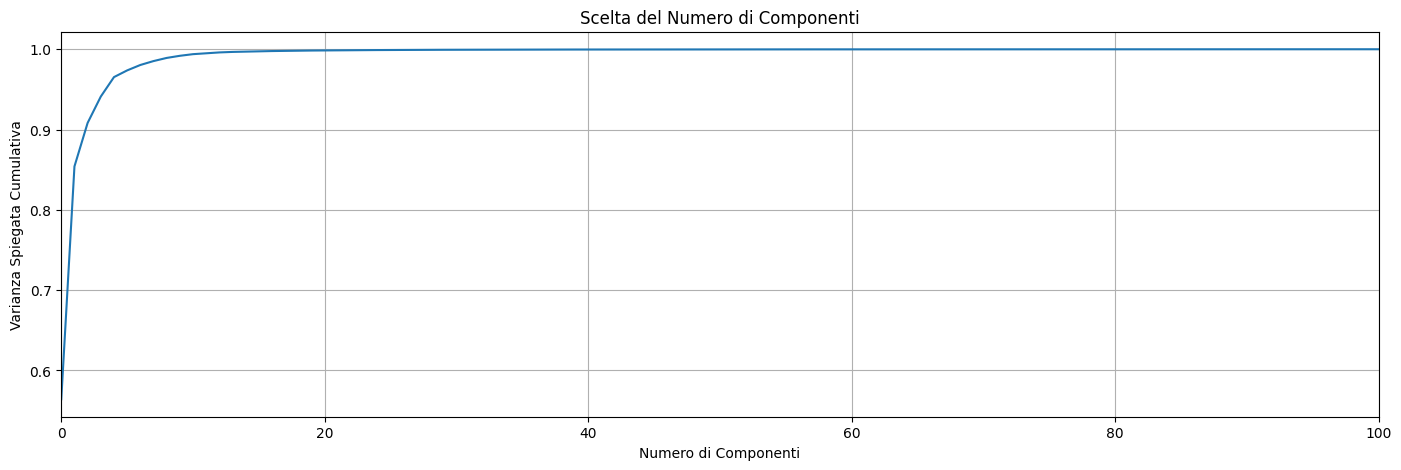

In [3]:
#PCA
from sklearn.decomposition import PCA

pca = PCA().fit(X)  # PCA senza specificare componenti
plt.xlim(0, 100)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Numero di Componenti")
plt.ylabel("Varianza Spiegata Cumulativa")
plt.title("Scelta del Numero di Componenti")
plt.grid()
plt.show()


In [11]:
d = 40
pca = PCA(n_components=d)  # Riduzione a 20 componenti
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
print("Forma originale:", X_train.shape)
print("Dopo PCA:", X_train.shape)


Forma originale: (19922, 40)
Dopo PCA: (19922, 40)


In [8]:
col_names = [name+"_"+stat+"_"+parameter for (name, stat, parameter) in X.columns]

important_features = np.abs(pca.components_[0])  # Prendi il valore assoluto della prima componente
feature_importance = list(zip(col_names, pca.explained_variance_ratio_))
feature_importance.sort(key=lambda x: x[1], reverse=True)  # Ordina per importanza
pca_feature_importance = feature_importance[:20]

print("Varianza spiegata da ciascuna componente:", pca_feature_importance)
print("Varianza totale spiegata:", np.sum(pca.explained_variance_ratio_))

Varianza spiegata da ciascuna componente: [('chroma_cens_kurtosis_01', np.float64(0.554301935113502)), ('chroma_cens_kurtosis_02', np.float64(0.2984514975544481)), ('chroma_cens_kurtosis_03', np.float64(0.05605380815790474)), ('chroma_cens_kurtosis_04', np.float64(0.035670056141989856)), ('chroma_cens_kurtosis_05', np.float64(0.02202543266083876)), ('chroma_cens_kurtosis_06', np.float64(0.008155652429407165)), ('chroma_cens_kurtosis_07', np.float64(0.007008717489389667)), ('chroma_cens_kurtosis_08', np.float64(0.004402194384219758)), ('chroma_cens_kurtosis_09', np.float64(0.0036514415748467575)), ('chroma_cens_kurtosis_10', np.float64(0.002528827444995265)), ('chroma_cens_kurtosis_11', np.float64(0.0017553601585396617)), ('chroma_cens_kurtosis_12', np.float64(0.0013215435445002536)), ('chroma_cens_max_01', np.float64(0.0010685480774293987)), ('chroma_cens_max_02', np.float64(0.0006007614262021926)), ('chroma_cens_max_03', np.float64(0.00037048943878683423)), ('chroma_cens_max_04', np.f

# Softmax regression

In [33]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)

# Train the model on your dataset
model.fit(X_train, y_train)

# Predict on new data (e.g., X_test)
y_pred = model.predict(X_test)

print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred,y_test))

                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00         2
          Classical       0.13      0.17      0.15        47
            Country       0.00      0.00      0.00         4
     Easy Listening       0.00      0.00      0.00         0
         Electronic       0.42      0.36      0.39       735
       Experimental       0.15      0.12      0.13       282
               Folk       0.08      0.13      0.10        89
            Hip-Hop       0.26      0.17      0.20       344
       Instrumental       0.07      0.20      0.10        59
      International       0.02      0.04      0.03        51
               Jazz       0.28      0.07      0.11       167
Old-Time / Historic       0.16      0.30      0.21        27
                Pop       0.04      0.08      0.06        60
               Rock       0.52      0.54      0.53       687
           Soul-RnB       0.00      0.00      0.00         6
             Spoken    

# Feedforward NN

In [37]:
# Feedforward neural network

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class MultiClassNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(d, d)
        self.act = nn.ReLU()
        self.output = nn.Linear(d, 16)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

y_train_tensor.shape

model = MultiClassNN()

# loss metric and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 6
batch_size = 200
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )

    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test_tensor)
    ce = loss_fn(y_pred, y_test_tensor)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test_tensor, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)


Using device: cpu


Epoch 0: 100%|██████████| 99/99 [00:00<00:00, 103.63batch/s, acc=0.32, loss=12.7] 


Epoch 0 validation: Cross-entropy=17.66, Accuracy=28.1%


Epoch 1: 100%|██████████| 99/99 [00:01<00:00, 92.60batch/s, acc=0.4, loss=5.91]   


Epoch 1 validation: Cross-entropy=10.79, Accuracy=32.9%


Epoch 2: 100%|██████████| 99/99 [00:01<00:00, 94.34batch/s, acc=0.425, loss=4.49] 


Epoch 2 validation: Cross-entropy=8.60, Accuracy=35.4%


Epoch 3: 100%|██████████| 99/99 [00:01<00:00, 95.02batch/s, acc=0.445, loss=3.9]  


Epoch 3 validation: Cross-entropy=7.43, Accuracy=36.4%


Epoch 4: 100%|██████████| 99/99 [00:01<00:00, 85.50batch/s, acc=0.455, loss=3.37] 


Epoch 4 validation: Cross-entropy=6.51, Accuracy=37.5%


Epoch 5: 100%|██████████| 99/99 [00:01<00:00, 97.47batch/s, acc=0.46, loss=2.99]  


Epoch 5 validation: Cross-entropy=5.75, Accuracy=37.6%


<All keys matched successfully>

In [38]:
y_test.shape

(2573,)

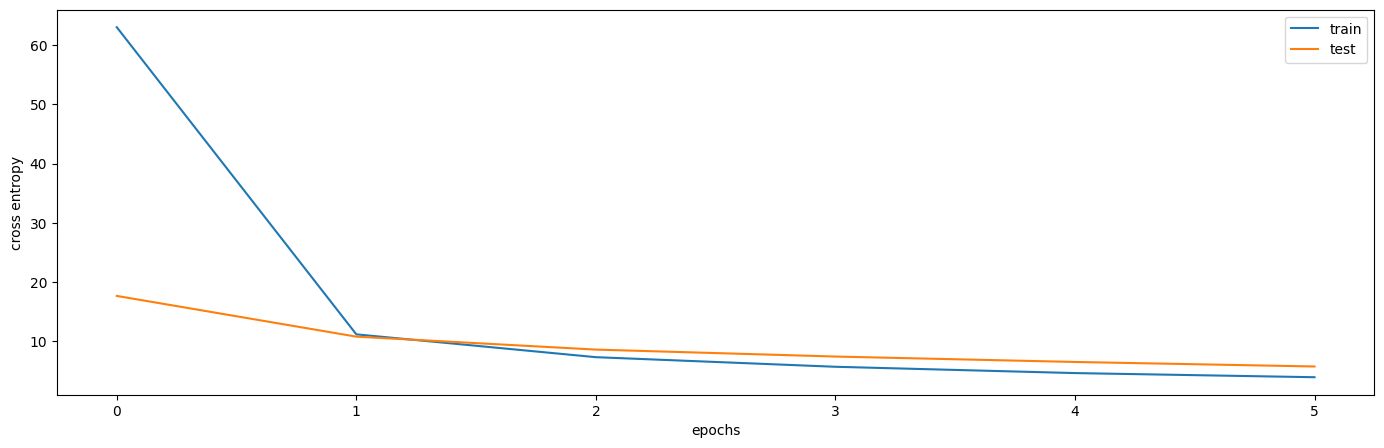

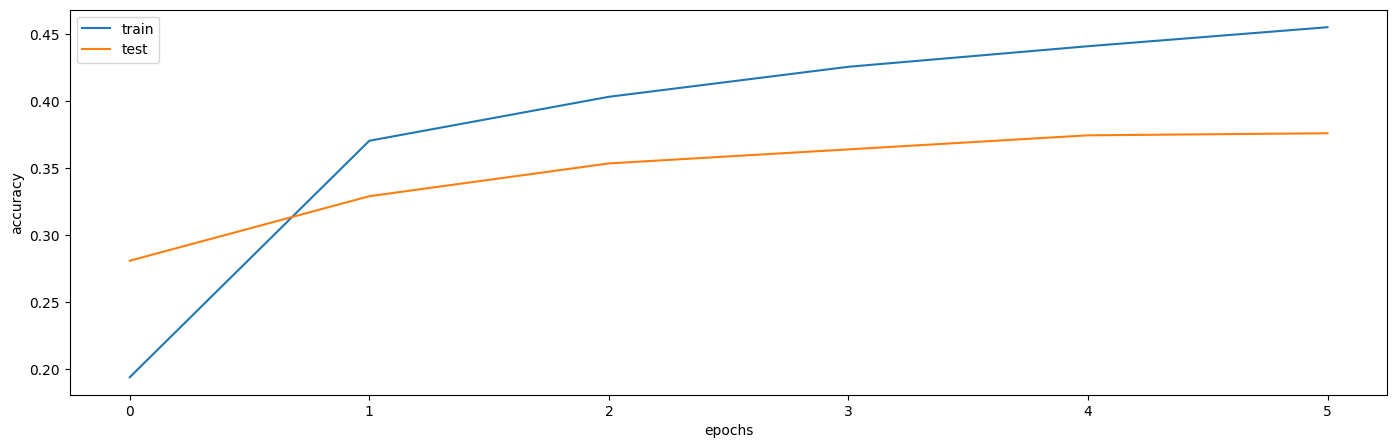

In [39]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Locally-weighted softmax regression 

In [ ]:
for x in X_test:

    # Query point (choose any test point)
    x_query = X_test[0].reshape(1, -1)  # Reshape to match training dimension

    # Compute weights using Gaussian kernel
    tau = 0.5  # Bandwidth parameter
    distances = np.linalg.norm(X_train - x_query, axis=1) ** 2
    weights = np.exp(-distances / (2 * tau**2))  # Gaussian weighting

    # Train weighted softmax regression
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
    model.fit(X_train, y_train, sample_weight=weights)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.00
Accuracy: 0.00
Accuracy: 0.00
Accuracy: 0.00
